# Custom car environment
## Solved using Q learning and neural networks

#### References
Inspiration for this project:
- https://towardsdatascience.com/reinforcement-learning-q-learning-with-decision-trees-ecb1215d9131
- https://www.semanticscholar.org/paper/Reinforcement-Learning-with-Decision-Trees-Pyeatt/f9b30e1f6d85cb77e95ff1d580ee67d7406f1dd6?p2df

In [48]:
import pygame
import numpy as np
import matplotlib.pyplot as plt
import torch
import sklearn
from collections import deque
import random
from math import sqrt
import timeit

BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255,0,0)
GREEN = (0,255,0)
BLUE = (0,0,255)

MAP_POINTS = [(0,100), (50,300), (10,400),(60,500), (200,560),
              (400,500),(500,400),(600,350),(700,325),
              (800,315),(900,800),(1100,800),(1000,600),
              (950,500),(975,400),(850,150),(500,300),
              (350,375),(250,410),(175,375),(120,350),(100,0)
             ]

#helpers
def slope(p1, p2) :
    return (p2[1] - p1[1]) * 1. / ((p2[0] - p1[0])+1e-5)
   
def y_intercept(slope, p1) :
    return p1[1] - 1. * slope * p1[0]
   
def intersect_p(line1, line2) :
    min_allowed = 1e-5
    big_value = 1e10
    m1 = slope(line1[0], line1[1])
    b1 = y_intercept(m1, line1[0])
    m2 = slope(line2[0], line2[1])
    b2 = y_intercept(m2, line2[0])
    if abs(m1 - m2) < min_allowed :
        x = big_value
    else :
        x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    y2 = m2 * x + b2
    return (int(x),int(y))

def segment_intersect(line1, line2) :
    intersection_pt = intersect_p(line1, line2)
    
    if (line1[0][0] < line1[1][0]) :
        if intersection_pt[0] < line1[0][0] or intersection_pt[0] > line1[1][0] :
            return None
    else :
        if intersection_pt[0] > line1[0][0] or intersection_pt[0] < line1[1][0] :
            return None
         
    if (line2[0][0] < line2[1][0]) :
        if intersection_pt[0] < line2[0][0] or intersection_pt[0] > line2[1][0] :
            return None
    else :
        if intersection_pt[0] > line2[0][0] or intersection_pt[0] < line2[1][0] :
            return None

    return intersection_pt

class Car():
    def __init__(self):
        self.center_pos = pygame.math.Vector2(50, 50)
        self.corners = [
            pygame.math.Vector2(-10,-20),
            pygame.math.Vector2(10,-20),
            pygame.math.Vector2(10,20),
            pygame.math.Vector2(-10,20)
        ]
        self.corners_pos = [x+self.center_pos for x in self.corners]
        self.sensors = [
            pygame.math.Vector2(0,1000),
            pygame.math.Vector2(966,258),
            pygame.math.Vector2(-966,258)
        ]
        self.sensors_pos = [x+self.center_pos for x in self.sensors]
        self.velocity = pygame.math.Vector2(0,10)
        self.angle = 0
        self.intersects = []
        self.signals = [0, 0, 0]
        
    def update(self, action):
       ##### next_state, reward, done
        angleChange = 10
        if action == 0: 
            angleChange = -10
        elif action == 1:
            angleChange = 0
        
        self.angle += angleChange
        self.angle = self.angle % 360
        self.center_pos = self.center_pos + self.velocity.rotate(self.angle)
        self.corners_pos = [x.rotate(self.angle)+self.center_pos for x in self.corners]
        self.sensors_pos = [x.rotate(self.angle)+self.center_pos for x in self.sensors]
        self.intersects = []
        self.signals = []
        for sensor in self.sensors_pos:
            sensor_intersects = []
            for i in range(len(MAP_POINTS)-1):
                intersect = segment_intersect([MAP_POINTS[i],MAP_POINTS[i+1]],[(self.center_pos.x,self.center_pos.y),(sensor.x,sensor.y)])
                if(intersect != None):
                    sensor_intersects.append(intersect)        
            if len(sensor_intersects) == 0:
                self.intersects.append((-100,-100))
                self.signals.append(1000)
            else:
                sensor_distances = [sqrt((x[0] - self.center_pos.x)**2 +(x[1] - self.center_pos.y)**2) for x in sensor_intersects]
                self.intersects.append(sensor_intersects[sensor_distances.index(min(sensor_distances))])
                self.signals.append(min(sensor_distances))
        
        #check car colision
        reward = 1
        reset = False
        for signal in self.signals:
            #Reset if hit a wall
            if signal < 15:
                self.reset()
                reset = True
                reward = -1
                break
            #Reset if out of map (this is a small bug in our simulation, which does not happen often)
            if self.center_pos.x < 0 or self.center_pos.x > 1000 or self.center_pos.y < 0 or self.center_pos.y > 700:
                self.reset()
                reset = True
                reward = 0
                break
            #Reset if reached goal
            if self.center_pos.x > 925 and self.center_pos.y > 625:
                self.reset()
                reset = True
                #set reward to 2 so that we know env has been solved
                reward = 2
                break
                
        next_state = []        
        for signal in self.signals:
            next_state.append(signal)
        next_state.append(self.angle)
        
        return next_state, reward, reset
                
    #reset car position
    def reset(self):
        self.__init__()

In [49]:
class NNpredictor():
    def __init__(self,input_shape,output_shape,exploration_min = 0.01, exploration_decay = 0.996,
                 exploration_rate = 1, batch_size = 32, gamma = 0.95, lr=0.001):
        
        #models hyperparameters
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.exploration_rate = exploration_rate
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        
        #model architecture
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_shape,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,output_shape),
        )
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        self.memory = deque(maxlen=1000000)
        
    def select_action(self,state):
        if np.random.rand() < self.exploration_rate:
            return random.randint(0,2)
        state = torch.from_numpy(np.array(state, dtype=np.float32)) 
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self,last_state,action,reward,next_state,done):
        self.memory.append((last_state,action,reward,next_state,done))
    

    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory,self.batch_size)
        for last_state, action, reward, next_state, done in batch:
            q_update = reward
            if not done:
                q_update = (reward + self.gamma * torch.amax(self.model(torch.from_numpy(np.array(next_state, dtype=np.float32)))).item())
            q_values = self.model(torch.from_numpy(np.array(last_state, dtype=np.float32)))
            q_values[action] = q_update

            #fit
            l = self.loss(self.model(torch.from_numpy(np.array(last_state, dtype=np.float32))), q_values)
            self.model.zero_grad()
            l.backward()
            self.optimizer.step()

        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [50]:
class MetricsLogger():
    
    def __init__(self):
        self.episodes_steps = np.array([])
        self.episodes_before_solve = np.array([])
        self.runs_logs = np.empty((0,3))
        
    def reset_run(self):
        self.episodes_steps = np.array([])
        self.episodes_before_solve = np.array([])

logs = MetricsLogger()

In [58]:
################################
# Training loop #
################################

pygame.init()
 
screen = pygame.display.set_mode([1000, 700])
 
pygame.display.set_caption('Comp 432 custom car env - Q learning NN')

car = Car()
clock = pygame.time.Clock()
exit = False
done = False
for run_i in range(5):
    if exit:
        break
    
    start = timeit.default_timer()
    num_solved = 0
    episode_i = 0
    episode_i_before_solve = 0
    logs.reset_run()
    
    #Init model
    model = NNpredictor(4,3)
    
    while num_solved < 5 and episode_i < 2000:
        if exit:
            break
        episode_i += 1
        car.reset()
        last_state = [1000, 1000, 1000, 0]
        steps = 0
        total_reward = 0
        episode_i_before_solve += 1
        
        while True:
            #allow for exit with X on window
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    exit = True
                    break
            # -- Draw everything
            # Clear screen
            screen.fill(BLACK)

            #draw map
            pygame.draw.lines(screen,WHITE,False,MAP_POINTS)

            #draw goal
            pygame.draw.circle(screen,GREEN,(950,650),20)

            #draw car
            pygame.draw.lines(screen,WHITE,True,[(vect.x,vect.y) for vect in car.corners_pos])


            #draw sensors
            for sensor in car.sensors_pos:
                pygame.draw.line(screen,GREEN,(car.center_pos.x,car.center_pos.y),(sensor.x,sensor.y))   

            for intersect in car.intersects:
                pygame.draw.circle(screen,RED,intersect,5)

            pygame.display.flip()
            clock.tick(120)

            steps += 1
            
            action = model.select_action(last_state)
            next_state, reward, done = car.update(action)
            model.remember(last_state,action,reward,next_state,done)
            model.experience_replay()

            total_reward += reward

            if done:
                print("Episode {} finished after {} steps with {} total reward".format(episode_i,steps,total_reward))
                if reward == 2:
                    print("reached goal")
                    logs.episodes_before_solve = np.append(logs.episodes_before_solve,episode_i_before_solve)
                    episode_i_before_solve = 0
                    num_solved += 1
                break

            last_state = next_state

        logs.episodes_steps = np.append(logs.episodes_steps,steps)

    stop = timeit.default_timer()
    print("Run {} done in {}".format(run_i,stop - start))
    
    logs.runs_logs = np.append(logs.runs_logs,[[logs.episodes_steps,logs.episodes_before_solve,stop - start]],axis=0)
    
pygame.quit()

Episode 1 finished after 12 steps with 10 total reward
Episode 2 finished after 15 steps with 13 total reward
Episode 3 finished after 16 steps with 14 total reward
Episode 4 finished after 9 steps with 7 total reward
Episode 5 finished after 18 steps with 16 total reward
Episode 6 finished after 10 steps with 8 total reward
Episode 7 finished after 13 steps with 11 total reward
Episode 8 finished after 16 steps with 14 total reward
Episode 9 finished after 62 steps with 60 total reward
Episode 10 finished after 20 steps with 18 total reward
Episode 11 finished after 14 steps with 12 total reward
Episode 12 finished after 22 steps with 20 total reward
Episode 13 finished after 27 steps with 25 total reward
Episode 14 finished after 25 steps with 23 total reward
Episode 15 finished after 148 steps with 146 total reward
Episode 16 finished after 60 steps with 58 total reward
Run 0 done in 19.432399299999815


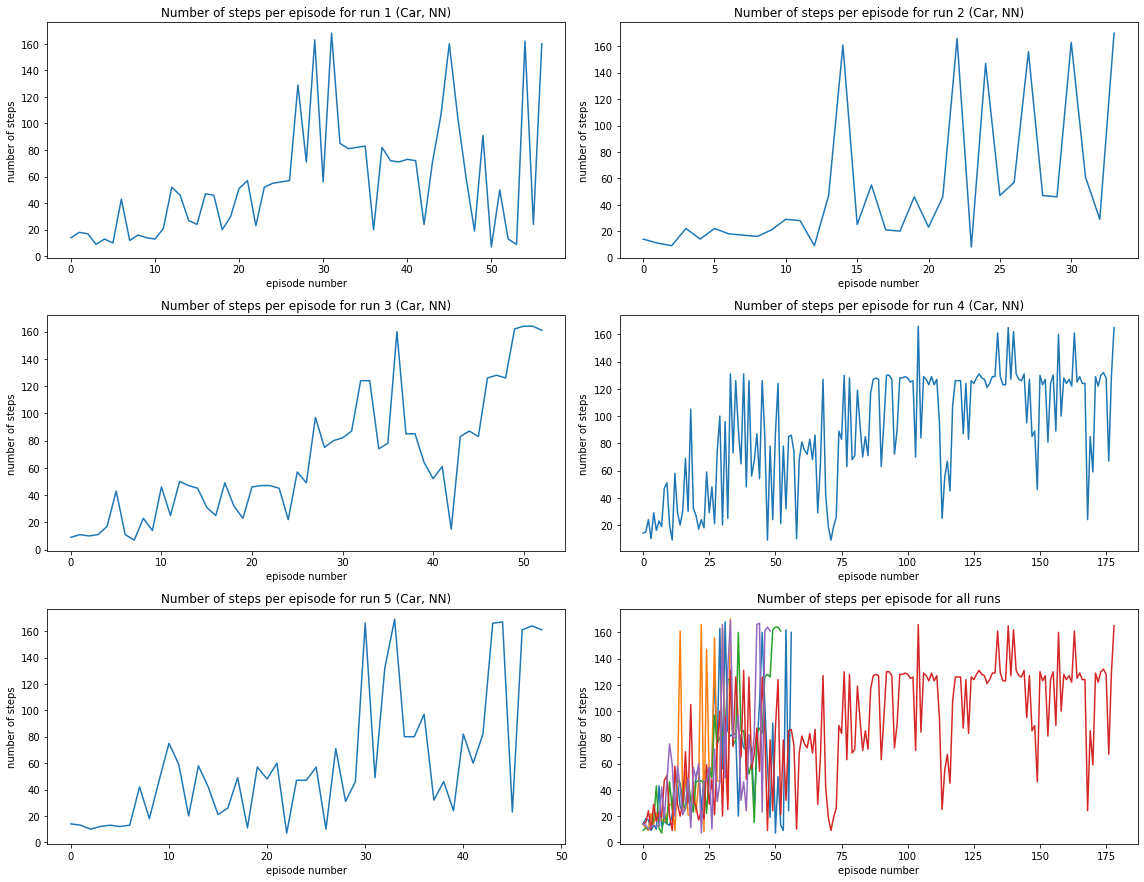

In [57]:
plt.figure(figsize=(16,16))
count = 0
for run_log in logs.runs_logs:
    count += 1
    plt.subplot(4,2,count,title="Number of steps per episode for run {} (Car, NN)".format(count))
    plt.plot(run_log[0])
    plt.xlabel("episode number")
    plt.ylabel("number of steps")
    
plt.subplot(4,2,count+1,title="Number of steps per episode for all runs")
for run_log in logs.runs_logs:
    plt.plot(run_log[0])
plt.xlabel("episode number")
plt.ylabel("number of steps")
    
plt.tight_layout()
plt.show;

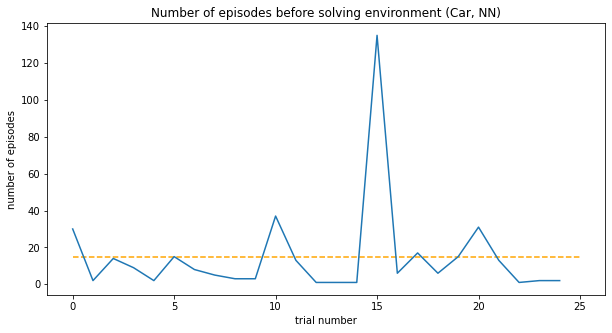

In [56]:
#####
# Everytime the env is solved, we look at the number of episodes it took before solving it.
# The peaks are at the start of each run, since the model is not yet trained.
####
cumul_episodes_before_solve = np.array([])
for run_log in logs.runs_logs:
    cumul_episodes_before_solve = np.append(cumul_episodes_before_solve,run_log[1])

average_episiodes_before_solve = np.sum(cumul_episodes_before_solve)/len(cumul_episodes_before_solve)

plt.figure(figsize=(10,5))
plt.plot(cumul_episodes_before_solve)
plt.hlines(average_episiodes_before_solve,0,25,linestyles="dashed",colors="orange")
plt.title("Number of episodes before solving environment (Car, NN)")
plt.xlabel("trial number")
plt.ylabel("number of episodes")
plt.show;

In [55]:
cumul_steps_per_eps = np.array([])
cumul_time_per_run = np.array([])
for run_log in logs.runs_logs:
    cumul_steps_per_eps = np.append(cumul_steps_per_eps,run_log[0])
    cumul_time_per_run = np.append(cumul_time_per_run,run_log[2])

print("\nTotal number of steps per run:")
run_count = 0
for run_log in logs.runs_logs:
    run_count += 1
    print("\tRun {}, total steps : {}".format(run_count,np.sum(run_log[0])))

print("\nTotal number of steps: {}".format(np.sum(cumul_steps_per_eps)))
print("Average number of steps per run: {}".format(np.sum(cumul_steps_per_eps)/5))
print("\nAverage time per run: {} seconds".format(np.sum(cumul_time_per_run)/5))
print("Average time per step: {:.2f} seconds".format(np.sum(cumul_steps_per_eps)/np.sum(cumul_time_per_run)))


Total number of steps per run:
	Run 1, total steps : 3211.0
	Run 2, total steps : 1771.0
	Run 3, total steps : 3469.0
	Run 4, total steps : 15847.0
	Run 5, total steps : 2977.0

Total number of steps: 27275.0
Average number of steps per run: 5455.0

Average time per run: 216.64579527999976 seconds
Average time per step: 25.18 seconds
